# Bayesian score

In [1]:
import numpy as np
import networkx as nx
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import random

# These functions are just the translation from Julia to Python of the functions in the notebook
def prior(vars, G):
    n = len(vars)
    r = [vars[i].r for i in range(n)]
    q = np.array([np.prod(np.array([r[j] for j in parent_node(G,i)])) for i in range(n)], dtype=int)
    return [(q[i], r[i]) for i in range(n)]

def sub2ind(siz, x):
    k = np.concatenate((np.array([1]), np.cumprod(siz[:-1])))
    return np.dot(k, x - 1) + 1

def statistics(vars, G, D):
    n = len(vars)
    r = [vars[i].r for i in range(n)]
    q = np.array([np.prod(np.array([r[j] for j in parent_node(G,i)])) for i in range(n)], dtype=int)
    M = [np.zeros((q[i], r[i])) for i in range(n)]

    for var_index in range(n):
        parents = parent_node(G,var_index)
        r_parents = np.array([vars[j].r for j in parents])
        has_no_parent = len(parents) == 0
        D2 = D.groupby(by=[vars[i].name for i in [var_index] + (parents)])['count'].sum().reset_index()
        for index, row in D2.iterrows():
            k = row[0] - 1 # value of variable
            j = 0 if has_no_parent else sub2ind(r_parents, row[1:-1] - 1)
            M[var_index][j,k] += row[-1]
    return M

# Function modified because prior is uniform, only ones are in the alpha matrix.
# Only alpha_shape is necessary since all alpha values are equal to one. 
# p calculations were simplified because of alpha values of one. 

def bayesian_score_component(M, alpha_shape):
    # Calculate the sum of log-gamma values for 1 + M
    log_gamma_sum_1_plus_M = 0
    for row in M:
        for value in row:
            log_gamma_sum_1_plus_M += scipy.special.loggamma(1 + value)

    # Calculate the log of the factorial of (alpha_shape[1] - 1)
    log_factorial_alpha_shape = alpha_shape[0] * np.log(scipy.special.factorial(alpha_shape[1] - 1))

    # Calculate the sum of log-gamma values for alpha_shape[1] + sum(M, axis=1)
    log_gamma_sum_alpha_shape = 0
    for row in M:
        log_gamma_sum_alpha_shape += scipy.special.loggamma(alpha_shape[1] + np.sum(row))

    # Combine the results to calculate the final 'p' value
    p = log_gamma_sum_1_plus_M + log_factorial_alpha_shape - log_gamma_sum_alpha_shape

    return p

def bayesian_score(vars, G, D):
    n = len(vars)
    M = statistics(vars, G, D)
    alpha = prior(vars, G)
    return sum(bayesian_score_component(M[i], alpha[i]) for i in range(n))

def parent_node(G, i):
    return list(G.predecessors(i))

class Variable:
    def __init__(self, name, r):
        self.name = name
        self.r = r


# Additional functions

In [2]:
def load_gph(gph_file, vars, use_var_names=False):
    G = nx.DiGraph()
    if not use_var_names:
        G.add_nodes_from(list(range(len(vars))))
    else:
        G.add_nodes_from([vars[i].name for i in range(len(vars))])
    names2idx = {vars[i].name: i for i in range(len(vars))}
    with open(gph_file, 'r') as f:
        for line in f:
            edge = line.replace('\n', '').replace(' ', '').split(',')
            if not use_var_names:
                G.add_edge(names2idx[edge[0]], names2idx[edge[1]])
            else:
                G.add_edge(edge[0], edge[1])
    return G

def load_data(infile):
    df = pd.read_csv(infile, delimiter=',')
    df_max = df.max()
    var_names = list(df.columns)
    df = df.groupby(var_names).size().reset_index(name='count')
    vars = [Variable(var_names[i], df_max[i]) for i in range(len(var_names))]
    return df, vars

def plot_bayesian_network(bayesian_network, title, variable_names):
    pos = nx.spring_layout(bayesian_network)
    # Create a dictionary to map variable indices to their names
    variable_name_mapping = {i: variable_names[i] for i in range(len(variable_names))}
    # Replace node numbers with variable names in the plot
    labels = {node: variable_name_mapping[node] for node in bayesian_network.nodes()}
    nx.draw(bayesian_network, pos, labels=labels, with_labels=True, node_size=400, node_color="skyblue")
    plt.title(title)
    plt.show()

def write_gph(dag, idx2names, filename):
    with open(filename, 'w') as f:
        for edge in dag.edges():
            f.write("{}, {}\n".format(idx2names[edge[0]], idx2names[edge[1]]))


# Test Bayesian Score Function

In [3]:
# Load data
df, vars = load_data("example.csv")
G = load_gph("example.gph", vars)
# Score graph
expected_score = -132.57689402451837
score = bayesian_score(vars, G, df)
score_accuracy = 100 * (1 - (score - expected_score))
print("Score accuracy: {:.0f}%".format(score_accuracy))

Score accuracy: 100%


# Network Construction Algorithm

In [4]:
import networkx as nx
import itertools
import time

# Create a global cache for storing scores of Bayesian network structures
network_cache = {}

def algorithm(vars, D, num_iter, max_parents, data_name):
    best_bayesian_network = None
    best_score = -float('inf')

    # Reset the cache at the beginning of each dataset
    network_cache.clear()


    for _ in range(num_iter):
        # Generate a random initial Bayesian network structure
        initial_network = generate_random_network(vars, max_parents)  # You'll need to specify the max_parents value here
        
        # Convert the network to a string representation for caching
        network_str = str(list(initial_network.edges()))

        # Check if the network has been scored before
        if network_str in network_cache:
            improved_score = network_cache[network_str]
        else:
            # Score the initial network if not found in the cache
            improved_network, improved_score = hill_climb(vars, initial_network, D, max_parents)
            network_cache[network_str] = improved_score

        print(f"Iteration {_ + 1}/{num_iter} - Score: {improved_score}")
        if improved_score > best_score:
            best_bayesian_network = improved_network
            best_score = improved_score


    return best_bayesian_network, best_score


def generate_random_network(vars, max_parents):
    G = nx.DiGraph()
    n = len(vars)
    
    for i in range(n):
        G.add_node(i)
        
    for i in range(n):
        # Randomly assign a random number of parents to each variable, up to the maximum
        num_parents = random.randint(0, max_parents)
        
        if num_parents > 0:
            # Randomly select unique parents from the set of all variables
            parent_candidates = list(range(n))
            parent_candidates.remove(i)
            parents = random.sample(parent_candidates, num_parents)
            
            # Add edges to the Bayesian network
            for parent in parents:
                G.add_edge(parent, i)
    
    return G


def hill_climb(vars, initial_network, D, max_parents):
    current_network = initial_network
    current_score = bayesian_score(vars, initial_network, D)
    improved = True
    iteration = 0  # Initialize iteration counter

    while improved:
        improved = False
        best_score = current_score
        best_edge = None

        for i in current_network.nodes():
            parents = list(current_network.predecessors(i))
            remaining_parents = [p for p in range(len(vars)) if p != i and len(parents) < max_parents]

            for j in remaining_parents:
                temp_network = copy.deepcopy(current_network)  # Create a copy of the current network
                temp_network.add_edge(j, i)

                # Check for cycles
                if not nx.is_directed_acyclic_graph(temp_network):
                    continue  # Skip this edge if it creates a cycle

                temp_score = bayesian_score(vars, temp_network, D)

                if temp_score > best_score:
                    best_score = temp_score
                    best_edge = (j, i)

        if best_edge is not None:
            current_network.add_edge(*best_edge)
            current_score = best_score
            improved = True

            # Print the iteration number, current score, and the proposed change
            print(f"Iteration {iteration + 1}: Score={current_score:.2f}, Proposed Edge={best_edge}")
            iteration += 1

    return current_network, current_score




# Graphs calculations

In [5]:
# Load data and define the datasets
small_data_frame, small_variables = load_data("small.csv")
medium_data_frame, medium_variables = load_data("medium.csv")
large_data_frame, large_variables = load_data("large.csv")

small_variable_names = small_data_frame.columns.tolist()
medium_variable_names = medium_data_frame.columns.tolist()
large_variable_names = large_data_frame.columns.tolist()

Iteration 1/5 - Score: -3957.3463973809994
Iteration 1: Score=-4023.75, Proposed Edge=(5, 7)
Iteration 2: Score=-3971.96, Proposed Edge=(4, 1)
Iteration 3: Score=-3921.00, Proposed Edge=(7, 4)
Iteration 4: Score=-3898.02, Proposed Edge=(4, 0)
Iteration 5: Score=-3883.37, Proposed Edge=(3, 0)
Iteration 6: Score=-3875.61, Proposed Edge=(6, 7)
Iteration 2/5 - Score: -3875.6059678956344
Iteration 1: Score=-4049.88, Proposed Edge=(5, 7)
Iteration 2: Score=-4000.19, Proposed Edge=(4, 7)
Iteration 3: Score=-3969.61, Proposed Edge=(3, 6)
Iteration 4: Score=-3946.63, Proposed Edge=(4, 0)
Iteration 5: Score=-3931.98, Proposed Edge=(3, 0)
Iteration 6: Score=-3917.51, Proposed Edge=(3, 5)
Iteration 7: Score=-3914.57, Proposed Edge=(1, 5)
Iteration 3/5 - Score: -3914.5685190736785
Iteration 1: Score=-3961.96, Proposed Edge=(4, 1)
Iteration 2: Score=-3921.14, Proposed Edge=(7, 4)
Iteration 3: Score=-3884.39, Proposed Edge=(6, 3)
Iteration 4: Score=-3876.88, Proposed Edge=(5, 3)
Iteration 5: Score=-3

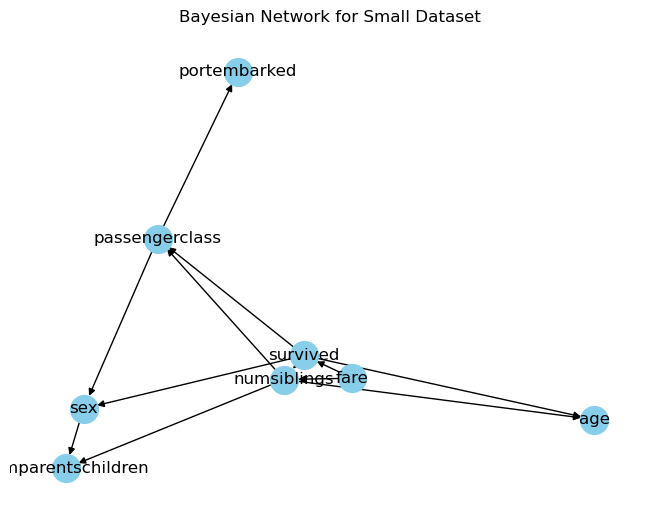

In [6]:
small_gph_filename = "small.gph"
small_idx2names = {i: small_variable_names[i] for i in range(len(small_variable_names))}
# Run Bayesian network structure learning for the small dataset
start_time = time.time()
best_small_bayesian_network, best_small_score = algorithm(small_variables, small_data_frame, num_iter=5, max_parents=2, data_name="small")
end_time = time.time()
print("Time taken for Small Dataset:", end_time - start_time, "seconds")
print("Best Bayesian Score for Small Dataset:", best_small_score)
plot_bayesian_network(best_small_bayesian_network, "Bayesian Network for Small Dataset", small_variable_names)
write_gph(best_small_bayesian_network, small_idx2names, small_gph_filename)

Iteration 1: Score=-44721.40, Proposed Edge=(3, 7)
Iteration 2: Score=-43978.66, Proposed Edge=(7, 10)
Iteration 3: Score=-43481.18, Proposed Edge=(10, 11)
Iteration 4: Score=-43139.37, Proposed Edge=(10, 6)
Iteration 5: Score=-42881.64, Proposed Edge=(0, 8)
Iteration 6: Score=-42784.67, Proposed Edge=(1, 10)
Iteration 7: Score=-42710.87, Proposed Edge=(0, 2)
Iteration 8: Score=-42660.86, Proposed Edge=(6, 9)
Iteration 9: Score=-42622.44, Proposed Edge=(10, 8)
Iteration 10: Score=-42610.70, Proposed Edge=(7, 0)
Iteration 11: Score=-42605.56, Proposed Edge=(7, 2)
Iteration 1/5 - Score: -42605.56417316392
Iteration 2/5 - Score: -45487.581743029004
Iteration 1: Score=-44262.89, Proposed Edge=(3, 7)
Iteration 2: Score=-43520.14, Proposed Edge=(7, 10)
Iteration 3: Score=-43022.67, Proposed Edge=(10, 11)
Iteration 4: Score=-42796.51, Proposed Edge=(6, 10)
Iteration 5: Score=-42725.34, Proposed Edge=(10, 9)
Iteration 6: Score=-42680.00, Proposed Edge=(10, 8)
Iteration 7: Score=-42650.80, Prop

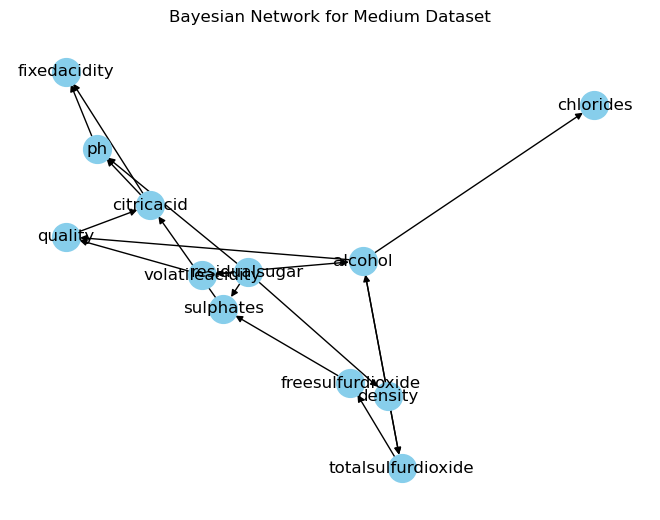

In [7]:
medium_gph_filename = "medium.gph"
medium_idx2names = {i: medium_variable_names[i] for i in range(len(medium_variable_names))}
# Run Bayesian network structure learning for the medium dataset
start_time = time.time()
best_medium_bayesian_network, best_medium_score = algorithm(medium_variables, medium_data_frame, num_iter=5, max_parents=2, data_name="medium")
end_time = time.time()
print("Time taken for Medium Dataset:", end_time - start_time, "seconds")
print("Best Bayesian Score for Medium Dataset:", best_medium_score)
plot_bayesian_network(best_medium_bayesian_network, "Bayesian Network for Medium Dataset", medium_variable_names)
write_gph(best_medium_bayesian_network, medium_idx2names, medium_gph_filename)

Iteration 1: Score=-479624.64, Proposed Edge=(46, 44)
Iteration 2: Score=-477123.17, Proposed Edge=(44, 47)
Iteration 3: Score=-474886.98, Proposed Edge=(2, 20)
Iteration 4: Score=-472776.10, Proposed Edge=(21, 48)
Iteration 5: Score=-470696.07, Proposed Edge=(7, 4)
Iteration 6: Score=-468670.50, Proposed Edge=(33, 3)
Iteration 7: Score=-466701.17, Proposed Edge=(25, 22)
Iteration 8: Score=-465129.45, Proposed Edge=(42, 16)
Iteration 9: Score=-463565.22, Proposed Edge=(26, 14)
Iteration 10: Score=-462065.30, Proposed Edge=(12, 24)
Iteration 11: Score=-459563.32, Proposed Edge=(17, 24)
Iteration 12: Score=-458342.26, Proposed Edge=(19, 35)
Iteration 13: Score=-456278.37, Proposed Edge=(25, 35)
Iteration 14: Score=-455182.98, Proposed Edge=(3, 43)
Iteration 15: Score=-454235.49, Proposed Edge=(14, 41)
Iteration 16: Score=-453293.91, Proposed Edge=(48, 18)
Iteration 17: Score=-452376.56, Proposed Edge=(26, 8)
Iteration 18: Score=-450255.28, Proposed Edge=(10, 8)
Iteration 19: Score=-44935

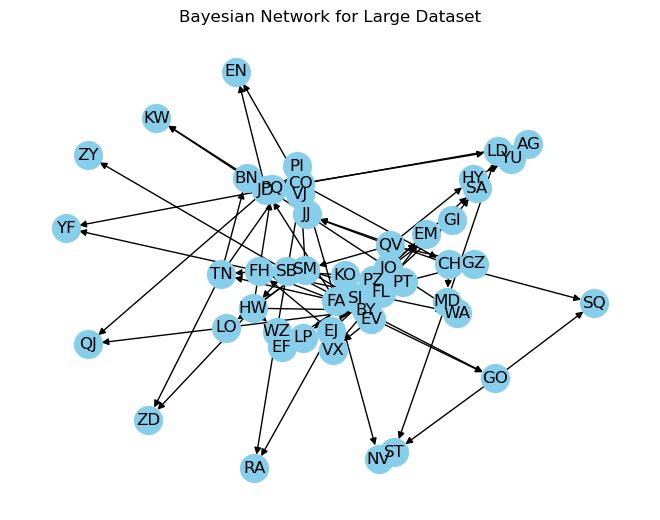

In [8]:
large_gph_filename = "large.gph"
large_idx2names = {i: large_variable_names[i] for i in range(len(large_variable_names))}
# Run Bayesian network structure learning for the large dataset
start_time = time.time()
best_large_bayesian_network, best_large_score = algorithm(large_variables, large_data_frame, num_iter=5, max_parents=2, data_name="large")
end_time = time.time()
print("Time taken for Large Dataset:", end_time - start_time, "seconds")
print("Best Bayesian Score for Large Dataset:", best_large_score)
plot_bayesian_network(best_large_bayesian_network, "Bayesian Network for Large Dataset", large_variable_names)
write_gph(best_large_bayesian_network, large_idx2names, large_gph_filename)


# BONUS: Compare with library pgmpy (Ungraded)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

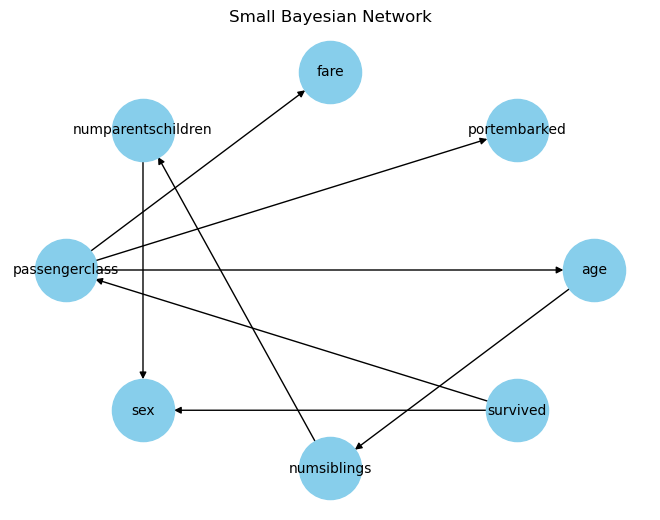

Small Bayesian Network BIC Score: -3853.18


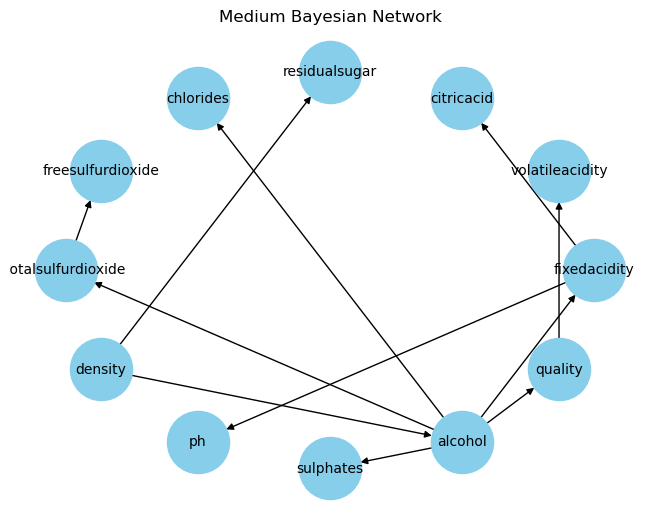

Medium Bayesian Network BIC Score: -42379.65


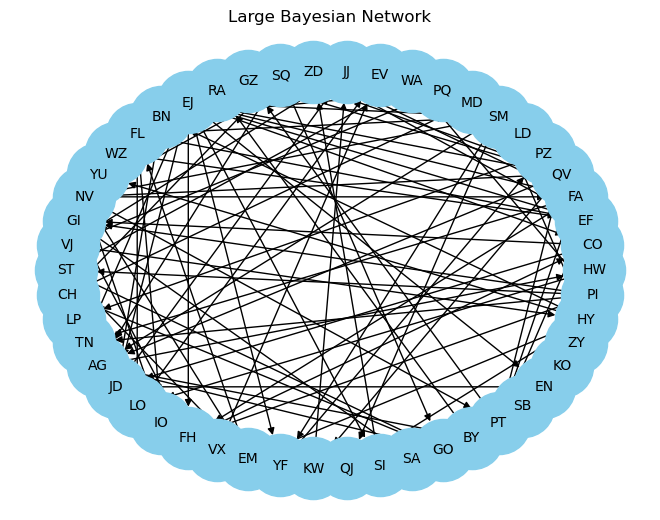

Large Bayesian Network BIC Score: -401087.11


In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore

# Load the CSV files (small.csv, medium.csv, large.csv)
small_data = pd.read_csv('small.csv')
medium_data = pd.read_csv('medium.csv')
large_data = pd.read_csv('large.csv')

# Define a function to create Bayesian network using Hill Climbing
def create_bayesian_network(data):
    hc = HillClimbSearch(data)
    best_model = hc.estimate(scoring_method=BicScore(data))
    return best_model

# Create Bayesian networks for the three datasets
small_bayesian_network = create_bayesian_network(small_data)
medium_bayesian_network = create_bayesian_network(medium_data)
large_bayesian_network = create_bayesian_network(large_data)

# Define a function to calculate and return the BIC score
def calculate_bic_score(bayesian_network, data):
    return BicScore(data).score(bayesian_network)

# Visualize the Bayesian networks and display scores
def plot_bayesian_network(bayesian_network, title, data):
    pos = nx.circular_layout(bayesian_network)
    labels = {node: node for node in bayesian_network.nodes()}
    nx.draw(bayesian_network, pos, with_labels=True, labels=labels, node_size=2000, node_color='skyblue', font_size=10, font_color='black')
    plt.title(title)
    plt.show()
    score = calculate_bic_score(bayesian_network, data)
    print(f"{title} BIC Score: {score:.2f}")

plot_bayesian_network(small_bayesian_network, "Small Bayesian Network", small_data)
plot_bayesian_network(medium_bayesian_network, "Medium Bayesian Network", medium_data)
plot_bayesian_network(large_bayesian_network, "Large Bayesian Network", large_data)